## Predicting Bulldozer Prices using regression on time-series data

In this project we're going to run through an example of an ML project with a goal of predicting the sale price of bulldozers.

https://www.kaggle.com/competitions/bluebook-for-bulldozers


## 1. Project Definition
How well can we predict the future sale price of a bulldozer given its characteristics and previous examples of sales data?

## 2. Data
We've grabbed data from an old Kaggle competition.
* Train data - collected through 2011
* Validation data - collected from Jan 2012 to April 2012
* Test data - collected from May 2012 to November 2012

## 3. Evaluation
The evaluation metric for this project is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

## 4. Features
The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
* saledate: the date of the sale

There are several fields towards the end of the file on the different options a machine can have.  The descriptions all start with "machine configuration" in the data dictionary.  Some product types do not have a particular option, so all the records for that option variable will be null for that product type.  Also, some sources do not provide good option and/or hours data.

The machine_appendix.csv file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).

**Imports for our toolkit**

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import training and validation sets
df = pd.read_csv("TrainAndValid.csv",
                low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

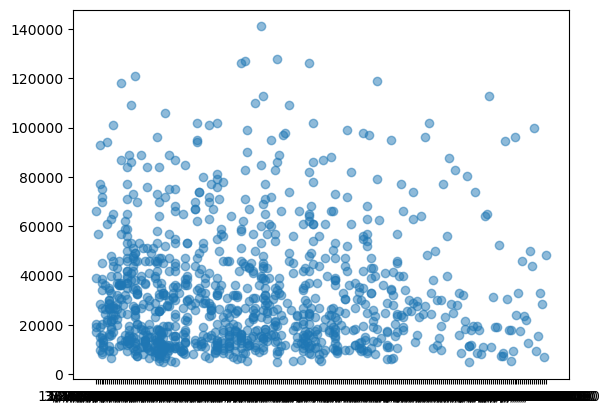

In [5]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:999], df["SalePrice"][:999],
          alpha=0.5)

We can see how there's an issue with the X axis - there's too many dates for us to show.

<AxesSubplot: ylabel='Frequency'>

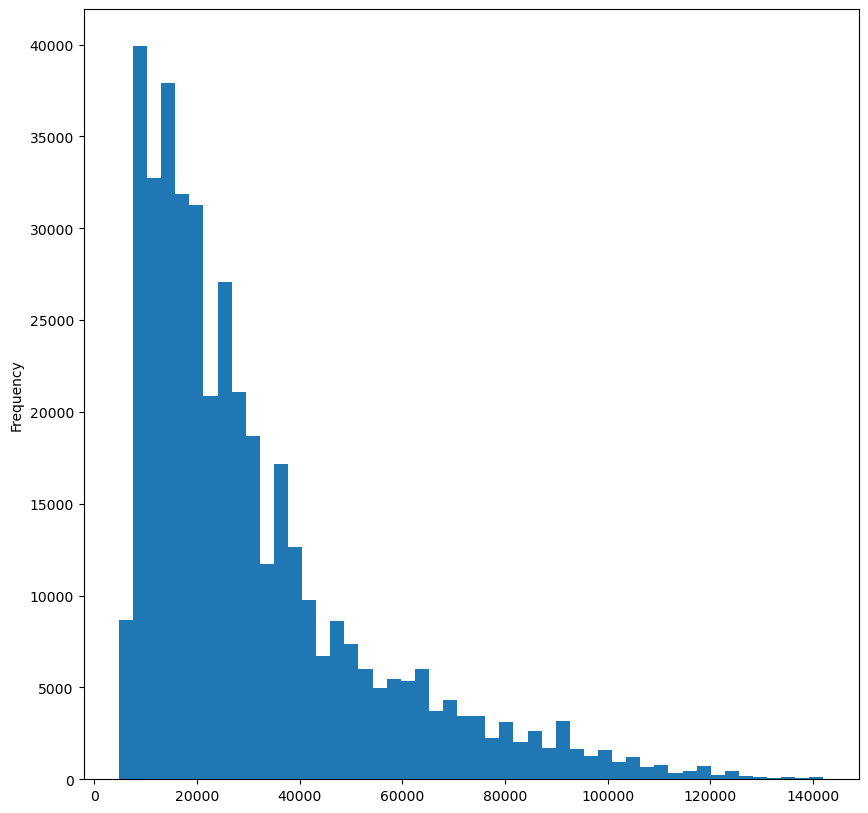

In [6]:
plt.figure(figsize=(10,10))
df.SalePrice.plot.hist(bins=50)

## Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter

In [7]:
# Re-import data but this time parse dates
df = pd.read_csv("TrainAndValid.csv",
                low_memory=False,
                parse_dates=["saledate"])

In [8]:
df.saledate.dtype

dtype('<M8[ns]')

In [9]:
df.saledate[:10]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

The dtype `<M8[ns]` is the datatype code for datetime64

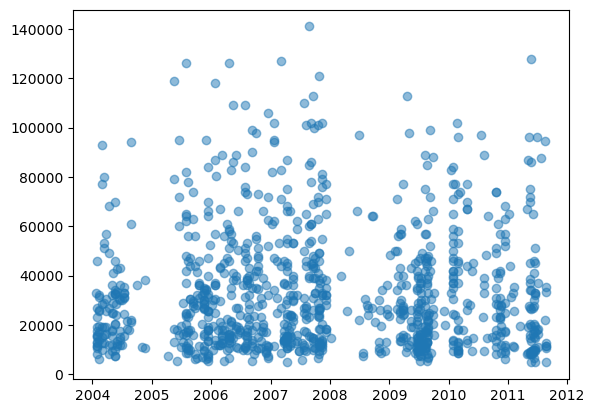

In [10]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:999],
          df["SalePrice"][:999],
          alpha=0.5)

In [11]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [13]:
df.saledate[:20]

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

In [14]:
# Sort DataFrame by saledate

df.sort_values("saledate")[:50]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
54653,1301884,23500.0,1182999,4123,132,99.0,1976,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
81383,1379228,31000.0,1082797,7620,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
204924,1645390,11750.0,1527216,8202,132,99.0,1970,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
135376,1493279,63000.0,1363756,2759,132,99.0,1987,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
113390,1449549,13000.0,1289412,3356,132,99.0,1966,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df.sort_values(by=["saledate"],
               inplace=True,
               ascending=True)

df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

## Make a copy of the original dataframe
We do this so when we manipulate our copy we can always bring back the original dataset

In [16]:
df_tmp = df.copy()

In [17]:
df_tmp.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

## Feature Engineering - enriching the dataset!
This means either creating a new feature or modifying an existing feature to enhance a dataset.

## We will add datetime parameters for `saledate` column

In [18]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [19]:
df_tmp.head(5).T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


Now, we don't really need the saledate anymore since we've already enriched our DataFrame with datetime features

In [20]:
df_tmp.drop("saledate", axis=1, inplace=True)

In [24]:
df_tmp.saledate

AttributeError: 'DataFrame' object has no attribute 'saledate'

In [26]:
df_tmp.state.value_counts()[:10]

Florida        67320
Texas          53110
California     29761
Washington     16222
Georgia        14633
Maryland       13322
Mississippi    13240
Ohio           12369
Illinois       11540
Colorado       11529
Name: state, dtype: int64

## 5. Modelling

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA

In [27]:
# Let's build an ML model

In [28]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

model.fit(df_tmp.drop("SalePrice",axis=1), df_tmp["SalePrice"])

ValueError: could not convert string to float: 'Low'

**We're seeing this error because we still need to manage our missing values and we need to do encoding on non-numeric values**

## Convert Strings to Categories

In [29]:
df_tmp.head(5).T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [30]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [31]:
# Find the columns that contain strings

columns_to_convert = []

for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype((content)):
        columns_to_convert.append(label)
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [32]:
# If you're wondering what df.items() does, here's an example

random_dict = {"key1":"hello!",
               "key2":"friends!"}

for key, value in random_dict.items():
    print(f"this is a key: {key} \n and this is a value: {value}")

this is a key: key1 
 and this is a value: hello!
this is a key: key2 
 and this is a value: friends!


In [33]:
columns_to_convert

['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls']

In [34]:
# This will turn all of the string values into category values:

for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [35]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [36]:
df_tmp.head(5).T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [37]:
# everything has been ordered! (alphabetically)
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [38]:
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

**Thanks to pandas Categories, we now have a way to access all of our data in the form of numbers.**

We've assigned a numerical value to each category (under the hood), similar to OneHotEncoder. Look:

In [39]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

**We still have a bunch of missing data**

In [40]:
(np.round(df_tmp.isnull().sum()/len(df_tmp),2)).sort_values(ascending=False)

Blade_Width                 0.94
Scarifier                   0.94
Blade_Extension             0.94
Enclosure_Type              0.94
Tip_Control                 0.94
Engine_Horsepower           0.94
Pushblock                   0.94
Hydraulics_Flow             0.89
Grouser_Tracks              0.89
Coupler_System              0.89
fiModelSeries               0.86
Differential_Type           0.83
Steering_Controls           0.83
fiModelDescriptor           0.82
UsageBand                   0.82
Stick                       0.80
Travel_Controls             0.80
Blade_Type                  0.80
Backhoe_Mounting            0.80
Pad_Type                    0.80
Turbocharged                0.80
Tire_Size                   0.76
Thumb                       0.75
Track_Type                  0.75
Undercarriage_Pad_Width     0.75
Stick_Length                0.75
Pattern_Changer             0.75
Grouser_Type                0.75
Ripper                      0.74
Drive_System                0.74
MachineHou

## Save preprocessed data

In [41]:
# Export current tmp dataframe
df_tmp.to_csv("train_tmp.csv",
             index=False)

In [42]:
# Import preprocessed data
df_tmp = pd.read_csv("train_tmp.csv",
                    low_memory=False)

df_tmp.head(5).T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


# Fill Missing Values
## Fill numerical missing values first

In [43]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [44]:
df_tmp.ModelID

0          8434
1         10150
2          4139
3          8591
4          4089
          ...  
412693     5266
412694    19330
412695    17244
412696     3357
412697     4701
Name: ModelID, Length: 412698, dtype: int64

In [45]:
# Check which numeric columns have null values

for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum()>0:
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [46]:
# fill numeric rows with the median and add a column which tells us if the data was missing
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum()>0:
            # Add column which tells us if the data was missing
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [47]:
# Let's check if we have any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
        else:
            print("None!")

None!
None!
None!
None!
None!
None!
None!
None!
None!
None!
None!
None!
None!
None!
None!


In [48]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

In [49]:
(np.round(df_tmp.isnull().sum()/len(df_tmp),2)).sort_values(ascending=False)

Enclosure_Type                         0.94
Scarifier                              0.94
Blade_Extension                        0.94
Blade_Width                            0.94
Tip_Control                            0.94
Engine_Horsepower                      0.94
Pushblock                              0.94
Hydraulics_Flow                        0.89
Grouser_Tracks                         0.89
Coupler_System                         0.89
fiModelSeries                          0.86
Differential_Type                      0.83
Steering_Controls                      0.83
fiModelDescriptor                      0.82
UsageBand                              0.82
Stick                                  0.80
Travel_Controls                        0.80
Blade_Type                             0.80
Backhoe_Mounting                       0.80
Pad_Type                               0.80
Turbocharged                           0.80
Tire_Size                              0.76
Thumb                           

# Now let's fill Categorical Missing values!

In [50]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [51]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether the sample has a missing value or not
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes + 1

In [52]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

***We add the 1 because pandas, by default, sets missing values to a code of -1 and we do not want that***

In [53]:
df_tmp.head(5).T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [54]:
df_tmp.isna().sum().sort_values()

SalesID                         0
Ride_Control_is_missing         0
Pad_Type_is_missing             0
Forks_is_missing                0
Enclosure_is_missing            0
                               ..
Enclosure_Type                  0
Blade_Width                     0
Blade_Extension                 0
Coupler                         0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [55]:
df_tmp.head(1)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True


***Now that all of our data is numeric as well our dataframe has no missing values, we should be able to build an ML model***

Actually we still need to split the data

# Splitting data into train/validation sets

In [56]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [57]:
df_tmp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [58]:
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [59]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]

In [60]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [61]:
y_train.head()

0     9500.0
1    14000.0
2    50000.0
3    16000.0
4    22000.0
Name: SalePrice, dtype: float64

In [62]:
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]

In [63]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

## Let's create our own evaluation function

In [64]:
# Create evaluation function
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def RMSLE(y_true, y_pred):
    """
    Calculate root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Create function to evalaute model on a few different levels

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": RMSLE(y_train, train_preds),
              "Valid RMSLE": RMSLE(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

## Testing our model on a subset to tune our hyperparameters

In [65]:
# Change max samples value!
model = RandomForestRegressor(n_jobs=-1,
                             random_state=42,
                             max_samples=10000)

model

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [66]:
%%time
# Cutting down on the max number of samples each estimator can see will improve our training time
model.fit(X_train, y_train)

CPU times: total: 59.6 s
Wall time: 5.86 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [67]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

**Let's prep RandomizedSearchCV with a dictionary**

In [68]:
%%time

from sklearn.model_selection import RandomizedSearchCV

rs_grid = {"n_estimators":np.arange(10,100,10),
              "max_depth":[None, 3, 5, 10],
              "min_samples_split":np.arange(2,20,2),
              "min_samples_leaf":np.arange(1,20,2),
              "max_features":[0.5, 1, "sqrt", "auto"],
              "max_leaf_nodes":[None, 3, 5, 10],
              "max_samples":[10000]}

# Instantiate RandomizedSearchCV
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                             param_distributions=rs_grid,
                             n_iter=20,
                             cv=5,
                             verbose=True)

# Fit RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\JohnC\Desktop\BulldozerProject\env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\JohnC\Desktop\BulldozerProject\env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\JohnC\Desktop\BulldozerProject\env\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this pa

CPU times: total: 1min 25s
Wall time: 2min 34s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_leaf_nodes': [None, 3, 5, 10],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [69]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 6,
 'min_samples_leaf': 11,
 'max_samples': 10000,
 'max_leaf_nodes': 10,
 'max_features': 0.5,
 'max_depth': 10}

In [70]:
show_scores(rs_model)

{'Training MAE': 10939.800864537103,
 'Valid MAE': 12361.12108152108,
 'Training RMSLE': 0.4755947746446282,
 'Valid RMSLE': 0.4812449904246541,
 'Training R^2': 0.5550897885473143,
 'Valid R^2': 0.5686512572474901}

## Train a model with the best hyperparameters
***These were found after 100 iterations of RandomizedSearchCV done by the instructor***

In [71]:
%%time

# Most ideal hyperparameters
my_ideal_model = RandomForestRegressor(n_estimators=30,
                                    min_samples_leaf=11,
                                    min_samples_split=16,
                                    max_features=1,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)

# Fit it!
my_ideal_model.fit(X_train, y_train)

CPU times: total: 24.7 s
Wall time: 2.6 s


RandomForestRegressor(max_features=1, min_samples_leaf=11, min_samples_split=16,
                      n_estimators=30, n_jobs=-1, random_state=42)

In [72]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)

# Fit it!
ideal_model.fit(X_train, y_train)

CPU times: total: 6min 7s
Wall time: 34.3 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [73]:
show_scores(ideal_model) # trained on all data

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.2452416398953833,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

In [74]:
show_scores(my_ideal_model) # trained on all data

{'Training MAE': 9421.59053861942,
 'Valid MAE': 11549.973766747846,
 'Training RMSLE': 0.4219423222451562,
 'Valid RMSLE': 0.4562153602672173,
 'Training R^2': 0.6578358915915613,
 'Valid R^2': 0.6126897187787504}

In [75]:
show_scores(rs_model) # trained on only 10000 samples

{'Training MAE': 10939.8008645371,
 'Valid MAE': 12361.121081521076,
 'Training RMSLE': 0.4755947746446282,
 'Valid RMSLE': 0.4812449904246541,
 'Training R^2': 0.5550897885473143,
 'Valid R^2': 0.5686512572474901}

In [76]:
df_test = pd.read_csv("Test.csv",
                     low_memory=False,
                     parse_dates=["saledate"])

In [77]:
df_test.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,1999,1000,2004,2006,2005
MachineHoursCurrentMeter,3688.0,28555.0,6038.0,8940.0,2286.0
UsageBand,Low,High,Medium,High,Low
saledate,2012-05-03 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00
fiModelDesc,580G,936,EC210BLC,330CL,650K


In [78]:
test_preds = ideal_model.predict(df_test)

C:\Users\JohnC\Desktop\BulldozerProject\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'Low'

## Make a test set copy

In [79]:
df_test_tmp = df_test.copy()

## Preprocessing the data (to get the test set to look exactly like the validation and training sets)

In [80]:
def preprocessing(df):
    """
    This is a function created to mirror the manipulations 
    we've done to the training and validation sets on the test set.
    """
    # Extracting datetime information
    
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate",
            axis=1,
           inplace=True)
    
    # Change strings to categories
    
    for label, contents in df.items():
        if pd.api.types.is_string_dtype(contents):
            df[label] = contents.astype("category").cat.as_ordered()
    
    # fill numeric rows with the median and add a column which tells us if the data was missing
    
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum()>0:
                # Add column which tells us if the data was missing
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
                
    # Turn categorical variables into numbers and fill missing
    
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            # Add binary column to indicate whether the sample has a missing value or not
            df[label+"_is_missing"] = pd.isnull(content)
            # Turn categories into numbers and add +1
            df[label] = pd.Categorical(content).codes + 1
    
    return df

In [81]:
df_test = preprocessing(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [82]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [83]:
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


**Finally, now our test dataframe has the same features as our training dataframe.  We can make predictions**

In [84]:
# Make predictions on the test data

test_preds = ideal_model.predict(df_test)
test_preds

C:\Users\JohnC\Desktop\BulldozerProject\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


array([20614.36780887, 19897.80170658, 44852.21959446, ...,
       14296.98620472, 22164.85757662, 31683.80063427])

**We've made predictions but they're not in the format needed for submitting to Kaggle**

In [85]:
# Format predictions into the same format Kaggle is after

In [86]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,20614.367809
1,1227844,19897.801707
2,1227847,44852.219594
3,1227848,68346.325323
4,1227863,39487.349708
...,...,...
12452,6643171,46466.092910
12453,6643173,17500.493352
12454,6643184,14296.986205
12455,6643186,22164.857577


In [87]:
# Export

df_preds.to_csv("test_predictions.csv",
               index=False)

## Feature Importance

In [88]:
feat_imp = ideal_model.feature_importances_

In [89]:
feat_imp.shape

(102,)

In [90]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features":columns,
                       "feature_importances":importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot df
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()
    ax.set_title("Top 20 Most Important Features to Sale Price")

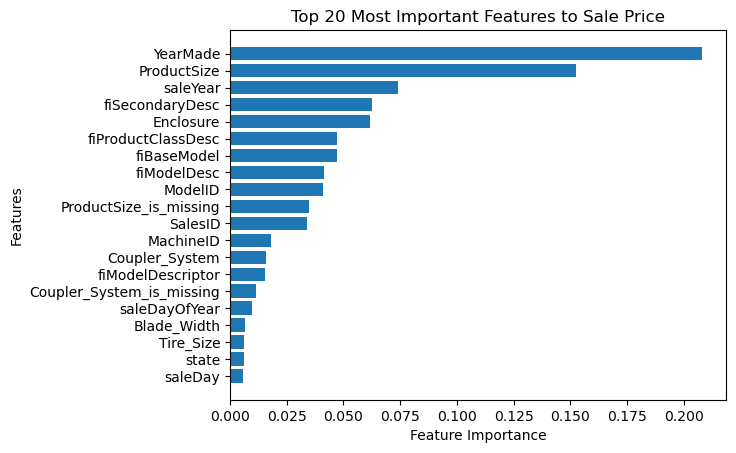

In [91]:
plot_features(X_train.columns,ideal_model.feature_importances_)